# Deep Convolution Generative Adversarial Network (DCGAN)

This solution was inspired by the solution developed in:

https://medium.com/@manoharmanok/implementing-dcgan-in-pytorch-using-the-celeba-dataset-a-comprehensive-guide-660e6e8e29d2

In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid
import torch.optim as optim

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("WARNING: CUDA not available. Running on CPU.")

In [19]:
# Set up variables
image_size = 64         # Desired size of input images, to match the GAN generated one
batch_size = 128        # Batch size during training
num_samples = 1000     # Number of samples to train on

In [20]:
# Normalise data
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [21]:
# Create train data
train_data = CelebA(root='C:/Users/Jacqu/Downloads/data/celeba', 
                    split='train', download=False, transform=transform_train)

Create a random subset of data so that we can ensure our model works before moving onto the full dataset:

In [22]:
# Create random indices for train and test datasets
train_indices = torch.randperm(len(train_data))[:num_samples]

# Create random subset of data
train_data = Subset(train_data, train_indices)

print(f"Num Train Subset Samples: {len(train_data)}")

Num Train Subset Samples: 1000


In [23]:
# Create DataLoader for train and test datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

To make sure this worked, let's show a random set of images from the dataloader:

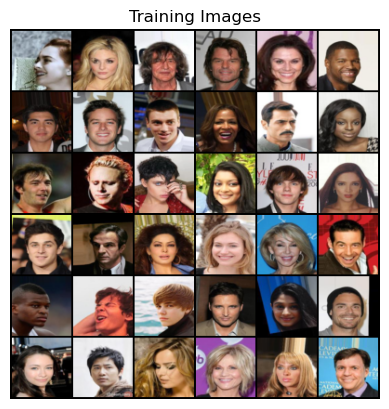

In [24]:
# Get a random batch of images
sample_batch = next(iter(train_loader))

# Make grid from the batch and normalise the images
# Need to permute since PyTorch tensors assume image channel is first dimensions
# but matplotlib assumes it is the third dimension
grid = vutils.make_grid(sample_batch[0][:36], normalize=True, nrow=6).permute(1,2,0)

plt.axis("off")
plt.title("Training Images")

# Convert to numpy array and plot
plt.imshow(np.array(grid))

## How a GAN works:

![Alt text](image-1.png)

So, the architecture of a GAN consists of two main components: the generator and the discriminator.

### The Generator
The generator takes random noise as input and gradually transforms it into fake images that resembles the training data. It does this through a series of layers, including:
- Transposed convolutions
- Batch normalisation
- Activation functions
These layers allow the generator to learn complex patterns and structures, resulting in it - over a number of epochs - being able to generate samples that capture the details of real data.

### The Discriminator
The discriminator acts as a binary classifier, all it needs to do is distinguish between real and generated samples. Similar to the generator, it receives input samples and passes them through:
- Convolutional layers
- Batch normalisation
- Activation functions
It's role is essentially just assessing the authenticity of samples and provide feedback (in terms of loss) to the generator.

Through an adversarial training process, these two models continuously compete and improve their performance, leading to the generation of better and more realistic samples.

In [25]:
# Hyperparameters
learning_rate = 0.0001  # Learning rate for model during optimisation
image_channels = 3      # Number of channels in input images (3 for RGB)
z_dim = 100             # Size of z latent space (i.e. size of generator input)
num_epochs = 10         # Number of training epochs
features_disc = 64      # Number of features in discriminator's convolutional layers
features_gen = 64       # Number of features in generator's convolutional layers

## Generator Network

The Generator architecture I followed looked like this:

![Alt text](image-6.png)

So, the input noise data, represented as a 100x1x1 tensor, undergoes a series of transposed convolutional operations to transform it into an output image of size 3x64x64 (RGB colour, with a standard size of 64).

By passing the noise data through these transposed convolutional layers, the generator gradually upscales the low-dim noise into high-dim image to match desired output.

The reshaping process involves increasing spatial dimensions while reducing the number of channels.

In [26]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, num_features_gen):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, num_features_gen * 16, 4, 1, 0), # output: [num_features_gen * 16, 4, 4]
            self._block(num_features_gen * 16, num_features_gen * 8, 4, 2, 1), # output: [num_features_gen * 8, 8, 8]
            self._block(num_features_gen * 8, num_features_gen * 4, 4, 2, 1), # output: [num_features_gen * 4, 16, 16]
            self._block(num_features_gen * 4, num_features_gen * 2, 4, 2, 1), # output: [num_features_gen * 2, 32, 32]
            # self._block(num_features_gen * 2, num_features_gen * 2, 4, 1, 1), # output: [num_features_gen * 2, 32, 32]
            nn.ConvTranspose2d(
                num_features_gen * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

The structure of the model is:
1. Input noise: 100x1x1
2. First transposed convolutional layer:
    - Output size: 1024x4x4
    - Kernel size: 4x4, stride: 1, padding: 0
3. Second transposed convolutional layer:
    - Output size: 512x8x8
    - Kernel size: 4x4, stride: 2, padding: 1
4. Third transposed convolutional layer:
    - Output size: 256x16x16
    - Kernel size: 4x4, stride: 2, padding: 1
5. Fourth transposed convolutional layer:
    - Output size: 128x32x32
    - Kernel size: 4x4, stride: 2, padding: 1
6. Final transposed convolutional layer:
    - Output size: 3x64x64
    - Kernel size: 4x4, stride: 2, padding: 1


The Generator class represents the generator network in the DCGAN architecture. It takes as input:
- z_dim: dimension of the latent space
- channels_img: number of channels in the output image
- num_features_gen: number of features for the generator

This network is a sequential model, which is just a linearly stacked set of layers that directly input and output to the layer before/after it.

The block function is just to simplify the code. It represents what operations occur in each layer:
- Transposed convolutional layer
- Batch normalisation
- ReLU activation function

As you can see, the block is repeated 4 times (this can also be increased due to the sequential nature of the model, say if the stride was reduced to 1, however this would result in increased computational time).

After these sequential blocks are computed, then the output image is passed through a specific type of activation function called a "hyperbolic tangent activation function", so that the pixel values are within the range [-1, 1].

In the forward function, the input noise is just passed through the sequential layers to eventually become a generated image.

Notes:
- nn.Tanh is used as it:
    - Helps the generated image match the distribution of the real image.
    - Assists in the stability during training (especially since GANs can go a bit wild with convergence)
- sigmoid will normalise images between [0, 1]
- tanh will normalise images between [-1, 1]

## Discriminator Network

<!-- ![Alt text](image-3.png) -->

The Discriminator architecture I followed looked like this:

![Alt text](image-7.png)

The Discriminator takes an input image (3x64x64, same as the generated and real images) and processes
it through a series of convolutional layers, resulting in a 1x1x1 output.

The model gradually reduces the spatial dimensions while increasing the number of channels. This allows
it to evaluate the image to determine whether it's real or not.

The 1x1x1 output is a single value that represents the probability of the input image being real or fake.

In [27]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, num_features_disc):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, num_features_disc, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(num_features_disc, num_features_disc * 2, 4, 2, 1),
            self._block(num_features_disc * 2, num_features_disc * 4, 4, 2, 1),
            self._block(num_features_disc * 4, num_features_disc * 8, 4, 2, 1),
            nn.Conv2d(num_features_disc * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

![Alt text](image-8.png)

In [28]:
def initialise_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [29]:
generator = Generator(z_dim, image_channels, features_gen).to(device)
discriminator = Discriminator(image_channels, features_disc).to(device)

initialise_weights(generator)
initialise_weights(discriminator)

In [30]:
opt_gen = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

In [31]:
def show_tensor_images(image_tensor, num_images=32, size=(1, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Epoch [1/10] Batch 1/8                     Loss D: 0.0876, loss G: 7.7438


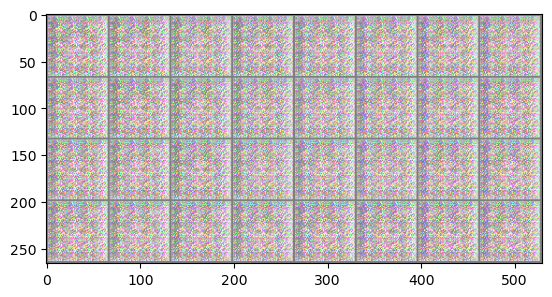

Epoch [2/10] Batch 1/8                     Loss D: 0.0531, loss G: 6.4524


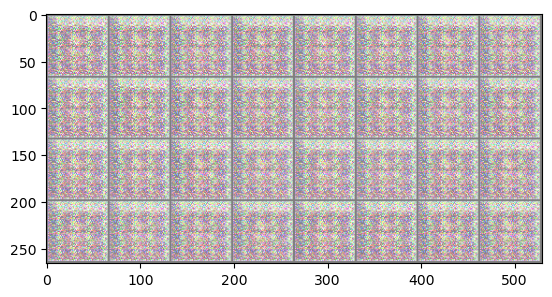

Epoch [3/10] Batch 1/8                     Loss D: 0.0746, loss G: 7.2292


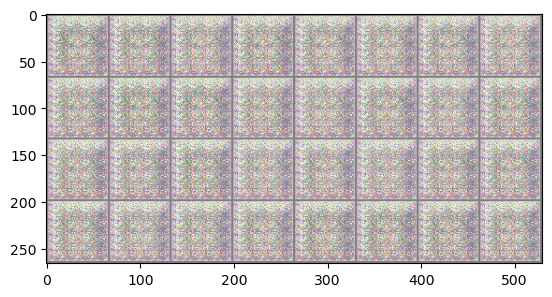

Epoch [4/10] Batch 1/8                     Loss D: 0.0382, loss G: 6.6735


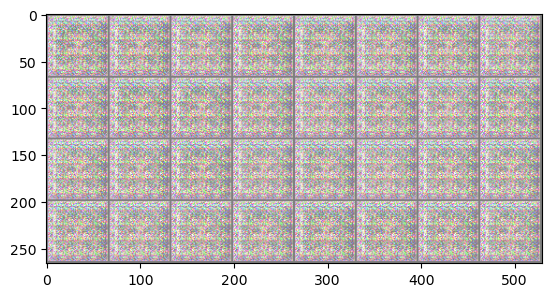

Epoch [5/10] Batch 1/8                     Loss D: 0.0506, loss G: 6.6263


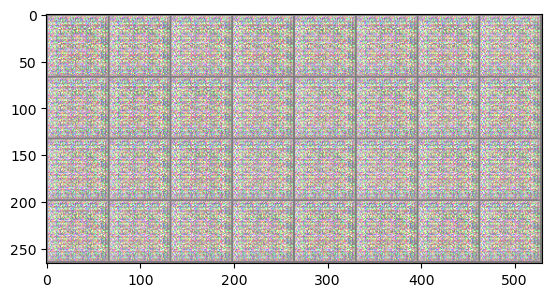

Epoch [6/10] Batch 1/8                     Loss D: 0.0254, loss G: 7.0112


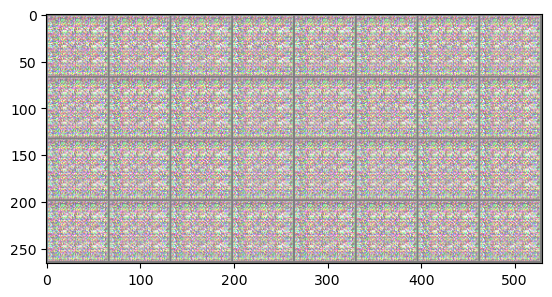

Epoch [7/10] Batch 1/8                     Loss D: 0.0376, loss G: 6.5539


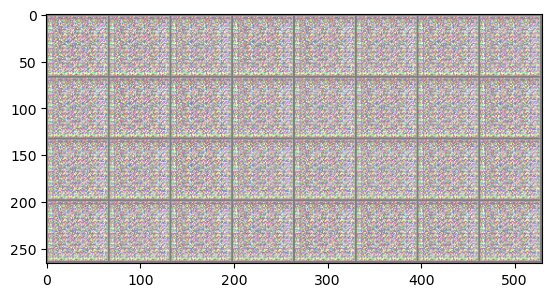

Epoch [8/10] Batch 1/8                     Loss D: 0.0301, loss G: 6.4946


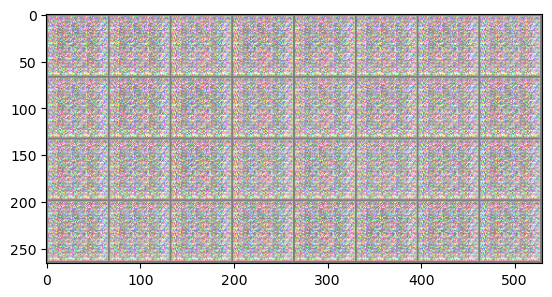

Epoch [9/10] Batch 1/8                     Loss D: 0.0192, loss G: 6.4495


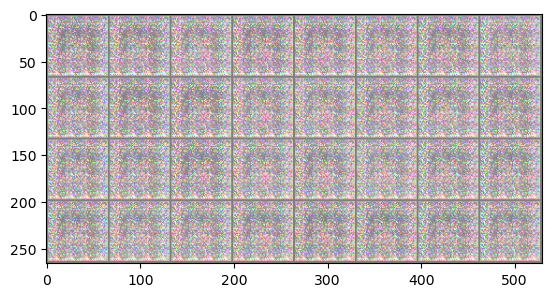

Epoch [10/10] Batch 1/8                     Loss D: 0.0332, loss G: 5.9895


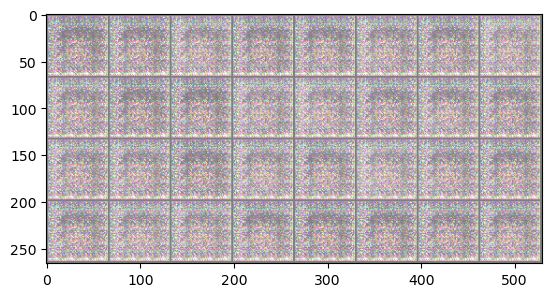

In [33]:
generator.train()
discriminator.train()

for epoch in range(1, num_epochs+1):
    for batch_idx, (real, _ ) in enumerate(train_loader):
        real = real.to(device)
        ### create noise tensor
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = generator(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = discriminator(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = discriminator(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        ### Print losses occasionally and fake images occasionally
        if (epoch % 1 == 0) and (batch_idx == 1):
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} \
                    Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = generator(fixed_noise)
                img_grid_fake = make_grid(fake[:32], normalize=True)
                show_tensor_images(img_grid_fake)